In [1]:
# Install pytorch-tabnet
!pip install pytorch-tabnet

# Install LightGBM
!pip install lightgbm

# Optional: Install scikit-learn-contrib for any additional functionalities
!pip install scikit-learn-contrib


ERROR: Could not find a version that satisfies the requirement scikit-learn-contrib (from versions: none)
ERROR: No matching distribution found for scikit-learn-contrib


In [2]:
!pip install dask-expr

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Traditional ML
import lightgbm as lgb

# Deep Learning Model
from pytorch_tabnet.tab_model import TabNetClassifier

# Explainable AI
import shap

# Meta-Learner
from sklearn.linear_model import LogisticRegression

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Replace 'fetal_health.csv' with your actual file path if different
data = pd.read_csv('/content/fetal_health.csv')

# Display the first five rows to verify
print("First five rows of the dataset:")
print(data.head())

# Check the shape of the dataset
print(f"Dataset Shape: {data.shape}")

# Convert 'fetal_health' to integer
data['fetal_health'] = data['fetal_health'].astype(int)

# Mapping numerical classes to descriptive labels
health_mapping = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}
data['fetal_health_label'] = data['fetal_health'].map(health_mapping)

# Features (all columns except 'fetal_health' and 'fetal_health_label')
X = data.drop(['fetal_health', 'fetal_health_label'], axis=1)

# Target variable
y = data['fetal_health']

# Split the data (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the resampled training data and transform
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train_resampled.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Verify scaling by checking means and standard deviations
print("\nMean of Scaled Training Features (Should be ~0):")
print(X_train_scaled.mean())

print("\nStandard Deviation of Scaled Training Features (Should be ~1):")
print(X_train_scaled.std())


First five rows of the dataset:
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5110
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       332
     Suspect       0.84      0.81      0.83        59
Pathological       0.86      0.91      0.89        35

    accuracy                           0.94       426
   macro avg       0.89   

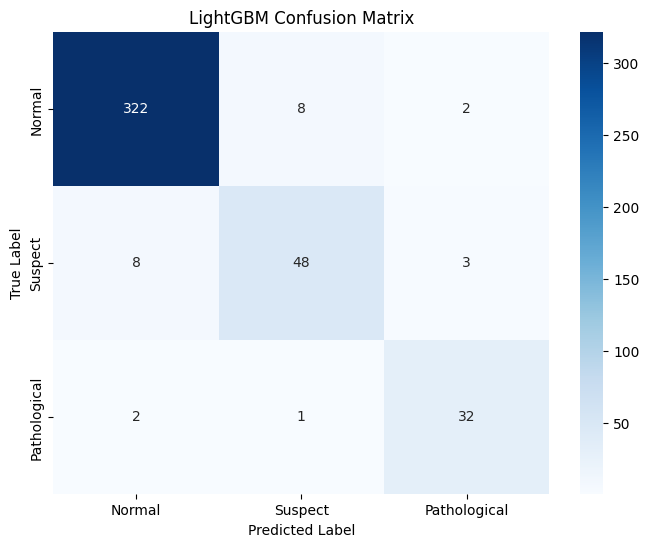

In [4]:
# Initialize the LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    objective='multiclass',
    class_weight='balanced',
    random_state=42
)

# Train the LightGBM model on the resampled and scaled training data
lgb_classifier.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_lgb = lgb_classifier.predict(X_test_scaled)

# Evaluate LightGBM performance
print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb, target_names=['Normal', 'Suspect', 'Pathological']))

# Confusion Matrix for LightGBM
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


epoch 0  | loss: 1.08343 | train_accuracy: 0.74074 | valid_accuracy: 0.67606 |  0:00:03s
epoch 1  | loss: 0.46399 | train_accuracy: 0.78609 | valid_accuracy: 0.76526 |  0:00:05s
epoch 2  | loss: 0.39552 | train_accuracy: 0.84656 | valid_accuracy: 0.87324 |  0:00:06s
epoch 3  | loss: 0.30245 | train_accuracy: 0.86521 | valid_accuracy: 0.84507 |  0:00:08s
epoch 4  | loss: 0.32991 | train_accuracy: 0.91484 | valid_accuracy: 0.86385 |  0:00:10s
epoch 5  | loss: 0.28965 | train_accuracy: 0.91988 | valid_accuracy: 0.88498 |  0:00:18s
epoch 6  | loss: 0.22813 | train_accuracy: 0.935   | valid_accuracy: 0.88263 |  0:00:22s
epoch 7  | loss: 0.23524 | train_accuracy: 0.94104 | valid_accuracy: 0.87324 |  0:00:25s
epoch 8  | loss: 0.23436 | train_accuracy: 0.92794 | valid_accuracy: 0.8615  |  0:00:29s
epoch 9  | loss: 0.22598 | train_accuracy: 0.93449 | valid_accuracy: 0.88498 |  0:00:33s
epoch 10 | loss: 0.21006 | train_accuracy: 0.93374 | valid_accuracy: 0.85915 |  0:00:35s
epoch 11 | loss: 0.24

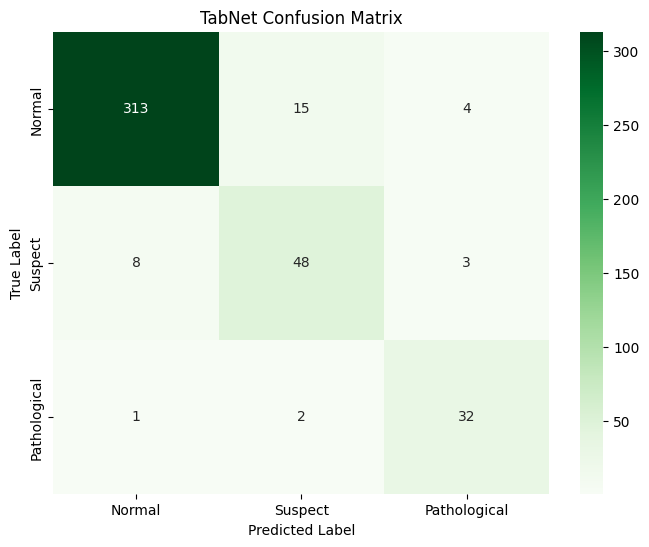

In [6]:
import torch


# Initialize the TabNet Classifier
tabnet_classifier = TabNetClassifier(
    n_d=64,                # Dimension of the decision step
    n_a=64,                # Dimension of the attention step
    n_steps=5,             # Number of steps in the architecture
    gamma=1.3,             # Relaxation parameter
    lambda_sparse=1e-3,    # Sparse regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax', # "sparsemax" or "entmax"
    verbose=1
)

# Train the TabNet model on the resampled and scaled training data
tabnet_classifier.fit(
    X_train=X_train_scaled.values,
    y_train=y_train_resampled.values,
    eval_set=[(X_train_scaled.values, y_train_resampled.values), (X_test_scaled.values, y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128
)

# Make predictions on the test set
y_pred_tabnet = tabnet_classifier.predict(X_test_scaled.values)

# Evaluate TabNet performance
print("\nTabNet Classification Report:")
print(classification_report(y_test, y_pred_tabnet, target_names=['Normal', 'Suspect', 'Pathological']))

# Confusion Matrix for TabNet
conf_matrix_tabnet = confusion_matrix(y_test, y_pred_tabnet)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tabnet, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('TabNet Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [8]:
# Generate predictions for training data using cross-validation to prevent overfitting

from sklearn.model_selection import KFold, StratifiedKFold

# Initialize KFold
n_folds = 5
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize arrays to hold out-of-fold predictions for training data
oof_preds_lgb = np.zeros((X_train_scaled.shape[0], 3))  # 3 classes
oof_preds_tabnet = np.zeros((X_train_scaled.shape[0], 3))  # 3 classes

# Initialize arrays to hold test set predictions
test_preds_lgb = np.zeros((X_test_scaled.shape[0], 3))
test_preds_tabnet = np.zeros((X_test_scaled.shape[0], 3))

print("Generating out-of-fold predictions...")

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_scaled, y_train_resampled)):
    print(f"Fold {fold + 1}")

    # Split data
    X_tr, X_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[valid_idx]
    y_tr, y_val = y_train_resampled.iloc[train_idx], y_train_resampled.iloc[valid_idx]

    # LightGBM
    lgb_fold = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        num_leaves=31,
        objective='multiclass',
        class_weight='balanced',
        random_state=42
    )
    lgb_fold.fit(X_tr, y_tr)
    oof_preds_lgb[valid_idx] = lgb_fold.predict_proba(X_val)
    test_preds_lgb += lgb_fold.predict_proba(X_test_scaled) / n_folds

    # TabNet
    tabnet_fold = TabNetClassifier(
        n_d=64,
        n_a=64,
        n_steps=5,
        gamma=1.3,
        lambda_sparse=1e-3,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        mask_type='sparsemax',
        verbose=0
    )
    tabnet_fold.fit(
        X_train=X_tr.values,
        y_train=y_tr.values,
        eval_set=[(X_val.values, y_val.values)],
        eval_name=['valid'],
        eval_metric=['accuracy'],
        max_epochs=100,
        patience=20,
        batch_size=256,
        virtual_batch_size=128
        # Removed 'reset=True' parameter
    )
    oof_preds_tabnet[valid_idx] = tabnet_fold.predict_proba(X_val.values)
    test_preds_tabnet += tabnet_fold.predict_proba(X_test_scaled.values) / n_folds

print("Out-of-fold predictions generated.")


Generating out-of-fold predictions...
Fold 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 3175, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.95088
Fold 2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You

In [9]:
# Create meta-features for the training set
meta_X_train = np.hstack((oof_preds_lgb, oof_preds_tabnet))

# Create meta-features for the test set
meta_X_test = np.hstack((test_preds_lgb, test_preds_tabnet))

# Define the meta-learner target
meta_y_train = y_train_resampled.values



Ensemble Model Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       332
     Suspect       0.83      0.81      0.82        59
Pathological       0.86      0.91      0.89        35

    accuracy                           0.94       426
   macro avg       0.89      0.90      0.89       426
weighted avg       0.94      0.94      0.94       426



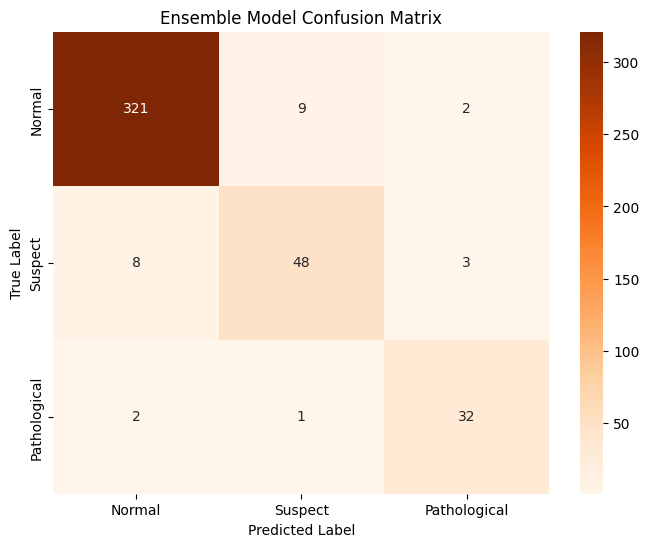

Ensemble Model Accuracy: 0.9413


In [10]:
# Initialize the Logistic Regression meta-learner
meta_learner = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Train the meta-learner on the meta-features
meta_learner.fit(meta_X_train, meta_y_train)

# Make predictions on the test set meta-features
y_pred_ensemble = meta_learner.predict(meta_X_test)

# Evaluate the Ensemble Model
print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=['Normal', 'Suspect', 'Pathological']))

# Confusion Matrix for Ensemble Model
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('Ensemble Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Overall Accuracy
accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")


In [11]:
# Individual Models' Accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
accuracy_tabnet = accuracy_score(y_test, y_pred_tabnet)

print(f"LightGBM Accuracy: {accuracy_lgb:.4f}")
print(f"TabNet Accuracy: {accuracy_tabnet:.4f}")
print(f"Ensemble Model Accuracy: {accuracy:.4f}")


LightGBM Accuracy: 0.9437
TabNet Accuracy: 0.9225
Ensemble Model Accuracy: 0.9413


In [12]:
# Coefficients of the meta-learner
meta_coefficients = meta_learner.coef_

# Create a DataFrame to display the coefficients
coeff_df = pd.DataFrame(meta_coefficients, columns=['LightGBM_Normal', 'LightGBM_Suspect', 'LightGBM_Pathological',
                                                    'TabNet_Normal', 'TabNet_Suspect', 'TabNet_Pathological'])

print("\nMeta-Learner Coefficients:")
print(coeff_df)



Meta-Learner Coefficients:
   LightGBM_Normal  LightGBM_Suspect  LightGBM_Pathological  TabNet_Normal  \
0         2.758106         -1.262713              -1.353910       1.691451   
1        -0.888154          2.183606              -1.212743       0.194530   
2        -1.869952         -0.920893               2.566653      -1.885982   

   TabNet_Suspect  TabNet_Pathological  
0       -0.309023            -1.240945  
1        0.965746            -1.077567  
2       -0.656723             2.318513  


In [13]:
import joblib

# Save the meta-learner
joblib.dump(meta_learner, 'meta_learner.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the LightGBM model
joblib.dump(lgb_classifier, 'lightgbm_model.pkl')

# Save the TabNet model
tabnet_classifier.save_model('tabnet_model.zip')

print("Models have been saved successfully.")


Successfully saved model at tabnet_model.zip.zip
Models have been saved successfully.


In [16]:
# Load the saved models
loaded_meta_learner = joblib.load('meta_learner.pkl')
loaded_lgb_classifier = joblib.load('lightgbm_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')

# Load the TabNet model
loaded_tabnet = TabNetClassifier()
loaded_tabnet.load_model('/content/tabnet_model.zip.zip')

# Example: Predicting on a new sample
# Replace 'new_sample' with actual data
# new_sample = pd.DataFrame({...})  # Ensure it has the same features as X

# For demonstration, we'll use the first instance from the test set
new_sample = X_test.iloc[[0]]
new_sample_scaled = loaded_scaler.transform(new_sample)

# Get base model predictions
lgb_pred_proba = loaded_lgb_classifier.predict_proba(new_sample_scaled)
tabnet_pred_proba = loaded_tabnet.predict_proba(new_sample_scaled)

# Create meta-features
meta_features = np.hstack((lgb_pred_proba, tabnet_pred_proba))

# Predict using the meta-learner
ensemble_pred = loaded_meta_learner.predict(meta_features)

# Map numerical prediction to labels
ensemble_pred_label = health_mapping[ensemble_pred[0]]
print(f"Ensemble Prediction for the new sample: {ensemble_pred_label}")


Ensemble Prediction for the new sample: Normal



Meta-Learner Coefficients:
              LightGBM_Normal  LightGBM_Suspect  LightGBM_Pathological  \
Normal               2.758106         -1.262713              -1.353910   
Suspect             -0.888154          2.183606              -1.212743   
Pathological        -1.869952         -0.920893               2.566653   

              TabNet_Normal  TabNet_Suspect  TabNet_Pathological  
Normal             1.691451       -0.309023            -1.240945  
Suspect            0.194530        0.965746            -1.077567  
Pathological      -1.885982       -0.656723             2.318513  


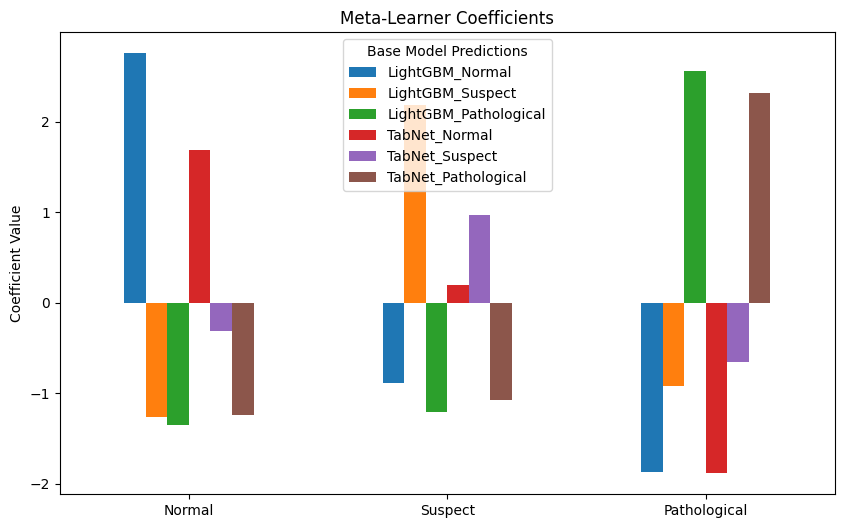

In [17]:
# Since the meta-learner is a Logistic Regression model, feature importances can be derived from its coefficients

# Create a DataFrame for meta-learner coefficients
meta_coefficients_df = pd.DataFrame(meta_learner.coef_, columns=['LightGBM_Normal', 'LightGBM_Suspect', 'LightGBM_Pathological',
                                                                 'TabNet_Normal', 'TabNet_Suspect', 'TabNet_Pathological'],
                                    index=['Normal', 'Suspect', 'Pathological'])

print("\nMeta-Learner Coefficients:")
print(meta_coefficients_df)

# Plot the coefficients
meta_coefficients_df.plot(kind='bar', figsize=(10, 6))
plt.title('Meta-Learner Coefficients')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=0)
plt.legend(title='Base Model Predictions')
plt.show()
